Import libraries

In [1]:
import os 
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy.stats import chi2_contingency
from matplotlib.patches import Patch, FancyBboxPatch
from utils import load_pickle, pickle_data, load_json

mkdir -p failed for path /afs/csail.mit.edu/u/k/klingmin/.config/matplotlib: [Errno 13] Permission denied: '/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-6e2q4e8a because there was an issue with the default path (/afs/csail.mit.edu/u/k/klingmin/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Settings

In [2]:
data_folder = "/data/rbg/users/klingmin/projects/MS_processing/data/"
splits_folder = "/data/rbg/users/klingmin/projects/MS_processing/data_splits"
results_folder = "/data/rbg/users/klingmin/projects/ML_MS_analysis/FP_prediction/mist/best_ls_results"
ls_plots_folder = os.path.join("./cache/ls_plots/plots")
if not os.path.exists(ls_plots_folder): os.makedirs(ls_plots_folder)

analysis_folder = "./cache/ls_plots"
if not os.path.exists(analysis_folder): os.makedirs(analysis_folder)

dataset_mapping = {"canopus": "NPLIB1", 
                   "massspecgym": "MassSpecGym",
                   "nist2023": "NIST2023"}

model_mapping = {"binned": "Binned-MLP",
                 "MS" : "MS-Transformer",
                 "formula": "CF-Transformer",
                 "MIST": "MIST"}

splits_mapping = {"scaffold_vanilla": "Scaffold split",
                  "inchikey_vanilla": "InChIKey split",
                  "random": "Random split", 
                  "ls": "LS split"}

NIST_instrument_mapping = {"Agilent QTOF 6530": "Agilent QTOF \n 6530",
                           "Thermo Finnigan Elite Orbitrap": "Thermo \n Finnigan \n Elite Orbitrap",
                           "Orbitrap Fusion Lumos": "Orbitrap \n Fusion Lumos",
                           "Thermo Finnigan Velos Orbitrap": "Thermo \n Finnigan \n Velos Orbitrap"}

instrument_colors = [ "#916953", "#B2675E", "#C4A381", "#F5ECCD", "#D6F6DD",]

adduct_colors = ["#0D5C63","#44A1A0", "#A8C7BB", "#C4F4C7"]

energy_colors = hex_colors = [
    "#e7e3d8",
    "#4b2c1a",
    "#a2753e",
    "#4d5c3d",
    "#b88e68",
    "#d1ac82",
    "#ceb29d",
    "#d4c3bc",
    "#dac2a6",
    "#98acab",
    "#bdc9bf",
    "#f7f6f4"
]

Helper Functions

In [3]:
def get_train_test_ratio(train_data, test_data):

    ratio = round(len(test_data) / (len(train_data) + len(test_data)) * 100, 3)

    return ratio

def get_percentage_mol_overlap(train_data, test_data):

    train_mols = set([r["inchikey_original"][:14] for r in train_data])
    test_mols = set([r["inchikey_original"][:14] for r in test_data])

    percent_overlap = round(len(train_mols.intersection(test_mols)) / len(test_data) * 100, 3)

    return percent_overlap

def get_oov_rate(train_data, test_data):
 
    train_formula = set([p["comment"]["f_pred"] for f in train_data for p in f["peaks"] if p["comment"]["f_pred"] != ""])
    test_formula = set([p["comment"]["f_pred"] for f in test_data for p in f["peaks"] if p["comment"]["f_pred"] != ""])

    oov_rate = len(test_formula - train_formula) / len(test_formula) * 100
    
    return oov_rate

def get_record_level_oov_rate(train_data, test_data):
 
    train_formula = set([p["comment"]["f_pred"] for f in train_data for p in f["peaks"] if p["comment"]["f_pred"] != ""])
    test_oov = [] 
    
    for f in test_data: 
        
        test_peaks = [p for p in f["peaks"] if p["comment"]["f_pred"] != ""]
        if len(test_peaks) == 0: 
            test_oov = 100
        else:
            test_oov = len(set(test_peaks).difference(train_formula)) / len(test_peaks) * 100

            test_oov.append(test_oov)

    return test_oov

def get_instrument_breakdown(train_data, test_data, key = "instrument_type"):
        
    train_instruments = collections.Counter([r[key] for r in train_data])
    test_instruments = collections.Counter([r[key] for r in test_data])

    unique_instruments = set(list(train_instruments.keys()) + list(test_instruments.keys()))

    train_instrument_counts = [train_instruments[i] if i in train_instruments else 0 for i in unique_instruments]
    test_instrument_counts = [test_instruments[i] if i in test_instruments else 0 for i in unique_instruments]

    return (train_instruments,train_instrument_counts), (test_instruments, test_instrument_counts), unique_instruments

def get_adduct_breakdown(train_data, test_data):
                
    train_adducts = collections.Counter([r["precursor_type"] for r in train_data])
    test_adducts = collections.Counter([r["precursor_type"] for r in test_data])

    unique_adducts = set(list(train_adducts.keys()) + list(test_adducts.keys()))

    train_adduct_counts = [train_adducts[i] if i in train_adducts else 0 for i in unique_adducts]
    test_adduct_counts = [test_adducts[i] if i in test_adducts else 0 for i in unique_adducts]

    return (train_adducts, train_adduct_counts), (test_adducts, test_adduct_counts), unique_adducts

def get_energy_breakdown(train_data, test_data):

    train_energies = collections.Counter([r["collision_energy"] for r in train_data])
    test_energies = collections.Counter([r["collision_energy"] for r in test_data])

    energy_bins = ["-", "0-20", "20-40", "40-60", "60-80", "80-100", "100-120", "120-150", ">150"]
    train_energies_binned = {b: 0 for b in energy_bins}
    test_energies_binned = {b: 0 for b in energy_bins}
    
    for e,c in train_energies.items():

        if e == "-": train_energies_binned["-"] += c 
        elif e is None: train_energies_binned["-"] += c
        elif e < 20: train_energies_binned["0-20"] += c 
        elif e < 40: train_energies_binned["20-40"] += c 
        elif e < 60: train_energies_binned["40-60"] += c 
        elif e < 80: train_energies_binned["60-80"] += c 
        elif e < 100: train_energies_binned["80-100"] += c 
        elif e < 120: train_energies_binned["100-120"] += c 
        elif e < 150: train_energies_binned["120-150"] += c 
        else: train_energies_binned[">150"] += c 

    for e,c in test_energies.items():

        if e == "-": test_energies_binned["-"] += c 
        elif e is None: test_energies_binned["-"] += c
        elif e < 20: test_energies_binned["0-20"] += c 
        elif e < 40: test_energies_binned["20-40"] += c 
        elif e < 60: test_energies_binned["40-60"] += c 
        elif e < 80: test_energies_binned["60-80"] += c 
        elif e < 100: test_energies_binned["80-100"] += c 
        elif e < 120: test_energies_binned["100-120"] += c 
        elif e < 150: test_energies_binned["120-150"] += c 
        else: test_energies_binned[">150"] += c 

    train_binned_energy_counts = [train_energies_binned[i] for i in test_energies_binned.keys()]
    test_binned_energy_counts = [test_energies_binned[i] for i in test_energies_binned.keys()]

    return (train_energies_binned, train_binned_energy_counts), (test_energies_binned, test_binned_energy_counts), energy_bins

def get_molecule_class(train_data, test_data):
    print()

Iterate through the various LS results to obtain the charts

In [7]:
for dataset in ["canopus", "massspecgym", "nist2023"]:

    current_data_folder = os.path.join(data_folder, dataset, "frags_preds")

    ls_results_folder = [os.path.join(results_folder, f) for f in os.listdir(results_folder) if dataset in f and "sieved" not in f]
    assert len(ls_results_folder) == 1
    ls_results_folder = ls_results_folder[0]

    stats_path = os.path.join(analysis_folder, f"{dataset}_ls_stats.pkl")
    if os.path.exists(stats_path): continue

    split = load_pickle(os.path.join(ls_results_folder, "best_split.pkl"))
    data_ids = load_pickle(os.path.join(ls_results_folder, "data_ids.pkl"))

    # Get the train and test data now
    train_ids = [data_ids[i].replace(".pkl", "") for i in split["train_indices"]]
    test_ids = [data_ids[i].replace(".pkl", "") for i in split["test_indices"]]

    train_data = [load_pickle(os.path.join(current_data_folder, f"{i}.pkl")) for i in train_ids]
    test_data = [load_pickle(os.path.join(current_data_folder, f"{i}.pkl")) for i in test_ids]
    
    # Get the train test ratio
    if dataset == "nist2023": instrument_key = "instrument"
    else: instrument_key = "instrument_type"
    stats = {} 
    stats["train_test_ratio"] = get_train_test_ratio(train_data, test_data)
    stats["percent_overlap"] = get_percentage_mol_overlap(train_data, test_data)
    stats["oov_rate"] = get_oov_rate(train_data, test_data) 
    stats["instrument_breakdown"]  = get_instrument_breakdown(train_data, test_data, key = instrument_key)
    stats["adduct_breakdown"] = get_adduct_breakdown(train_data, test_data)
    stats["energy_breakdown"] = get_energy_breakdown(train_data, test_data)

    # Add to the data 
    pickle_data(stats, stats_path)

Get the statistics for other splits

In [ ]:
for dataset in ["canopus", "massspecgym", "nist2023"]:

    for split in ["LS"]:

        current_data_folder = os.path.join(data_folder, dataset, "frags_preds")

        data_splits_folder = [os.path.join(splits_folder, f, "splits") for f in os.listdir(splits_folder) if dataset in f and "sieved" not in f]
        assert len(data_splits_folder) == 1
        data_splits_folder = data_splits_folder[0]
        data_split_path = os.path.join(data_splits_folder, f"{split}.json")
        data_split = load_json(data_split_path)
        assert os.path.exists(data_split_path)

        stats_path = os.path.join(analysis_folder, f"{dataset}_{split}_stats.pkl")
        if os.path.exists(stats_path): continue
        
        # Get the train and test data now
        train_ids = data_split["train"][:500]
        test_ids = data_split["test"][:500]

        train_data = [load_pickle(os.path.join(current_data_folder, f"{i}")) for i in train_ids]
        test_data = [load_pickle(os.path.join(current_data_folder, f"{i}")) for i in test_ids]

        print("HERE")
        a = z 

        # Get the train test ratio
        if dataset == "nist2023": instrument_key = "instrument"
        else: instrument_key = "instrument_type"
        stats = {} 
        stats["train_test_ratio"] = get_train_test_ratio(train_data, test_data)
        stats["percent_overlap"] = get_percentage_mol_overlap(train_data, test_data)
        stats["oov_rate"] = get_oov_rate(train_data, test_data) 
        stats["instrument_breakdown"]  = get_instrument_breakdown(train_data, test_data, key = instrument_key)
        stats["adduct_breakdown"] = get_adduct_breakdown(train_data, test_data)
        stats["energy_breakdown"] = get_energy_breakdown(train_data, test_data)

        # Add to the data 
        pickle_data(stats, stats_path)

Iterate through the various LS results to obtain OOV rate for sieved results

In [127]:
for dataset in ["massspecgym", "nist2023"]:

    current_data_folder = os.path.join(data_folder, dataset, "frags_preds")

    ls_results_folder = [os.path.join(results_folder, f) for f in os.listdir(results_folder) if dataset in f and "sieved" in f]
    assert len(ls_results_folder) == 1
    ls_results_folder = ls_results_folder[0]

    stats_path = os.path.join(analysis_folder, f"{dataset}_sieved_ls_stats.pkl")
    if os.path.exists(stats_path): continue

    split = load_pickle(os.path.join(ls_results_folder, "best_split.pkl"))
    data_ids = load_pickle(os.path.join(ls_results_folder, "data_ids.pkl"))

    # Get the train and test data now
    train_ids = [data_ids[i] for i in split["train_indices"]]
    test_ids = [data_ids[i] for i in split["test_indices"]]

    train_data = [load_pickle(os.path.join(current_data_folder, f"{i}.pkl")) for i in train_ids]
    test_data = [load_pickle(os.path.join(current_data_folder, f"{i}.pkl")) for i in test_ids]

    # Get the stats
    stats = {} 
    stats["train_test_ratio"] = get_train_test_ratio(train_data, test_data)
    stats["percent_overlap"] = get_percentage_mol_overlap(train_data, test_data)
    stats["oov_rate"] = get_oov_rate(train_data, test_data) 

    # Add to the data 
    pickle_data(stats, stats_path)

``Let us plot the histograms and compute the chi square test scores``

1. Plot the instrument split

p_value canopus ls 2.929435634257232e-10



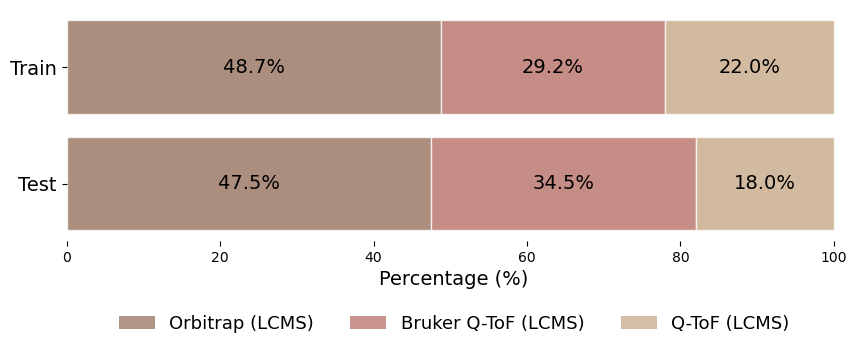

p_value massspecgym ls 0.0



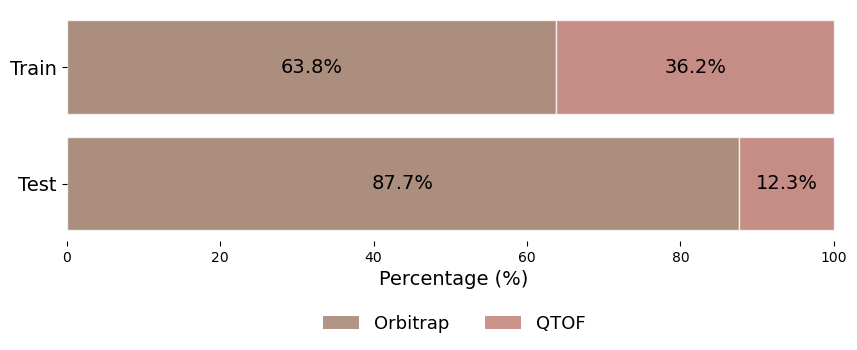

p_value nist2023 ls 9.885992028136842e-52



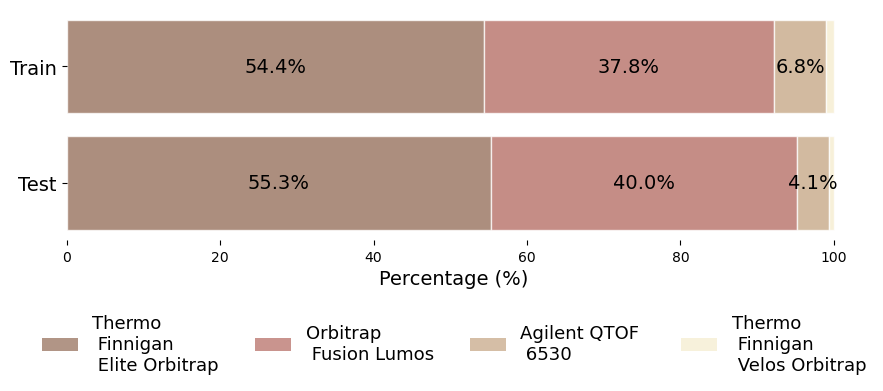

In [155]:
results_instruments = {}

# Choose your palette
color_palette = instrument_colors

for dataset in ["canopus", "massspecgym", "nist2023"]:

    results_instruments[dataset] = {}

    for split in ["ls"]:
        
        results_instruments[dataset][split] = {}
        stats = load_pickle(os.path.join(analysis_folder, f"{dataset}_{split}_stats.pkl"))

        (train_inst_breakdown, _), (test_inst_breakdown, _), _ = stats["instrument_breakdown"]

        unique_instruments = list(set(train_inst_breakdown) | set(test_inst_breakdown))
        unique_instruments = [u for u in unique_instruments if u is not None and "Unknown" not in u]

        # Filter
        if dataset == "canopus":
            unique_instruments = [u for u in unique_instruments if "Ion Trap" not in u and "FTICR" not in u]
        if dataset == "massspecgym":
            unique_instruments = [u for u in unique_instruments if u is not None]

        # Normalize to percentage
        train_total = sum(train_inst_breakdown.get(u, 0) for u in unique_instruments)
        test_total = sum(test_inst_breakdown.get(u, 0) for u in unique_instruments)

        train_inst_count = {u: train_inst_breakdown.get(u, 0) for u in unique_instruments}
        test_inst_count = {u: test_inst_breakdown.get(u, 0) for u in unique_instruments}

        train_inst_percent = {u: train_inst_breakdown.get(u, 0) / train_total * 100 if train_total > 0 else 0 for u in unique_instruments}
        test_inst_percent = {u: test_inst_breakdown.get(u, 0) / test_total * 100 if test_total > 0 else 0 for u in unique_instruments}

        # Example: counts of instruments in train and test sets
        data = pd.DataFrame({
            'Train': list(train_inst_count.values()),
            'Test': list(test_inst_count.values()),
        }, list(test_inst_count.keys()))

        print("p_value", dataset, split, chi2_contingency(data)[1])
        print()


        unique_instruments = sorted(unique_instruments, key=lambda u: train_inst_percent.get(u, 0), reverse = True)
        results_instruments[dataset][split]["counts"] = test_inst_breakdown

        # Create plot
        fig, ax = plt.subplots(figsize=(10, 3))
        bar_positions = [0, 1]  # 0 = Train, 1 = Test
        left_train = 0
        left_test = 0

        for i, instrument in enumerate(unique_instruments):
            
            color = color_palette[i % len(color_palette)]
            train_val = train_inst_percent[instrument]
            test_val = test_inst_percent[instrument]

            # Train bar
            ax.barh(bar_positions[0], train_val, left=left_train, color=color, edgecolor='white', alpha = 0.75)
            if train_val > 3:
                ax.text(left_train + train_val / 2, bar_positions[0], f"{train_val:.1f}%", ha='center', va='center', fontsize=14)
            left_train += train_val

            # Test bar
            ax.barh(bar_positions[1], test_val, left=left_test, color=color, edgecolor='white', alpha = 0.75)
            if test_val > 3:
                ax.text(left_test + test_val / 2, bar_positions[1], f"{test_val:.1f}%", ha='center', va='center', fontsize=14)
            left_test += test_val

        # Customize axis
        ax.grid(False)
        ax.set_yticks(bar_positions)
        ax.set_yticklabels(["Train", "Test"], fontsize=14)
        ax.set_xlim(0, 101)
        ax.set_xlabel("Percentage (%)", fontsize=14)

        # Legend
        if dataset == "nist2023":
            legend_labels = [NIST_instrument_mapping[u] for u in unique_instruments]
        else:
            legend_labels = unique_instruments

        # Match legend labels to colors
        legend_patches = [Patch(facecolor=color_palette[i % len(color_palette)],
                                label=NIST_instrument_mapping[u] if dataset == "nist2023" else u,
                                alpha=0.7)
                                for i, u in enumerate(unique_instruments)]

        ax.legend(labels = legend_labels, handles=legend_patches, loc="upper center", bbox_to_anchor=(0.5, -0.25),
                  ncol=len(legend_labels), fontsize=13, frameon=False)

        ax.invert_yaxis()  # Train on top
        ax.grid(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        # Save figure
        instrument_output_path = os.path.join(ls_plots_folder, f"{dataset}_{split}_instruments_stacked.jpg")
        plt.savefig(instrument_output_path, bbox_inches="tight")
        plt.show()

p_value canopus ls 2.2643933472321912e-08



<Figure size 900x600 with 0 Axes>

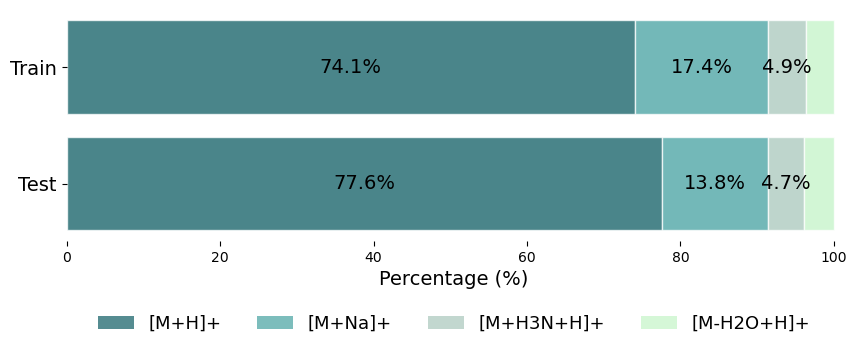

p_value massspecgym ls 2.3078922487476327e-77



<Figure size 900x600 with 0 Axes>

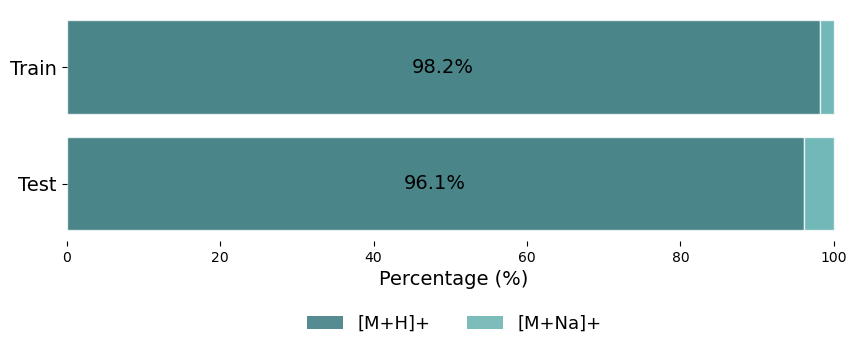

p_value nist2023 ls 0.0



<Figure size 900x600 with 0 Axes>

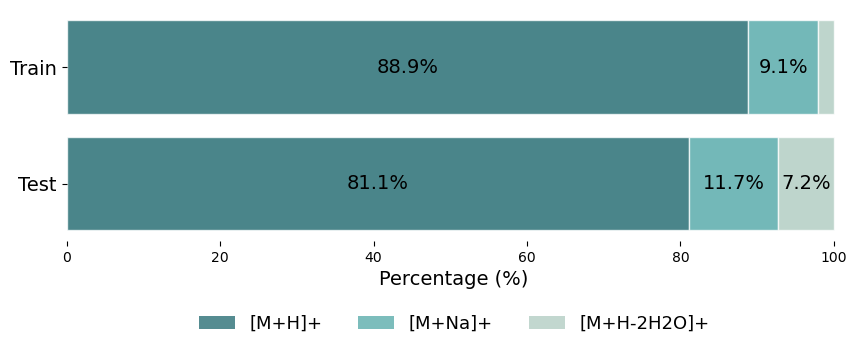

In [154]:
results_adduct = {}

# Choose your palette
color_palette = adduct_colors

for dataset in ["canopus", "massspecgym", "nist2023"]:

    results_adduct[dataset] = {} 

    for split in ["ls"]:
        
        results_adduct[dataset][split] = {} 
        
        stats = load_pickle(os.path.join(analysis_folder, f"{dataset}_{split}_stats.pkl"))

        plt.figure(figsize=(9, 6))

        (train_adduct_breakdown, _), (test_adduct_breakdown, _), _ = stats["adduct_breakdown"]
        unique_adducts = list(set(list(train_adduct_breakdown.keys()) + list(test_adduct_breakdown.keys())))
        
        # Filter
        if dataset == "canopus": unique_adducts = [u for u in unique_adducts if "[M]+" not in u and "[M+K]+" not in u]
        if dataset == "nist2023": unique_adducts = unique_adducts = ["[M+H]+", "[M+H-2H2O]+", "[M+Na]+"]

        # Normalize to percentage
        train_total = sum(train_adduct_breakdown.get(u, 0) for u in unique_adducts)
        test_total = sum(test_adduct_breakdown.get(u, 0) for u in unique_adducts)

        train_adduct_count = {u: train_adduct_breakdown.get(u, 0) for u in unique_adducts}
        test_adduct_count = {u: test_adduct_breakdown.get(u, 0) for u in unique_adducts}

        train_adduct_percent = {u: train_adduct_breakdown.get(u, 0) / train_total * 100 if train_total > 0 else 0 for u in unique_adducts}
        test_adduct_percent = {u: test_adduct_breakdown.get(u, 0) / test_total * 100 if test_total > 0 else 0 for u in unique_adducts}

        # Example: counts of instruments in train and test sets
        data = pd.DataFrame({
            'Train': list(train_adduct_count.values()),
            'Test': list(test_adduct_count.values()),
        }, list(test_adduct_count.keys()))

        print("p_value", dataset, split, chi2_contingency(data)[1])
        print()

        selected_adducts = sorted(unique_adducts, key=lambda u: train_adduct_percent.get(u, 0), reverse = True)

        results_adduct[dataset][split]["counts"] = test_inst_breakdown

        # Create plot
        fig, ax = plt.subplots(figsize=(10, 3))
        bar_positions = [0, 1]  # 0 = Train, 1 = Test
        left_train = 0
        left_test = 0

        for i, adduct in enumerate(selected_adducts):
            
            color = color_palette[i % len(color_palette)]
            train_val = train_adduct_percent[adduct]
            test_val = test_adduct_percent[adduct]

            # Train bar
            ax.barh(bar_positions[0], train_val, left=left_train, color=color, edgecolor='white', alpha = 0.75)
            if train_val > 4:
                ax.text(left_train + train_val / 2, bar_positions[0], f"{train_val:.1f}%", ha='center', va='center', fontsize=14)
            left_train += train_val

            # Test bar
            ax.barh(bar_positions[1], test_val, left=left_test, color=color, edgecolor='white', alpha = 0.75)
            if test_val > 4:
                ax.text(left_test + test_val / 2, bar_positions[1], f"{test_val:.1f}%", ha='center', va='center', fontsize=14)
            left_test += test_val

        # Customize axis
        ax.grid(False)
        ax.set_yticks(bar_positions)
        ax.set_yticklabels(["Train", "Test"], fontsize=14)
        ax.set_xlim(0, 101)
        ax.set_xlabel("Percentage (%)", fontsize=14)

        legend_labels = selected_adducts

        # Match legend labels to colors
        legend_patches = [Patch(facecolor=color_palette[i % len(color_palette)],
                                label=u,
                                alpha=0.7)
                                for i, u in enumerate(selected_adducts)]

        ax.legend(labels = legend_labels, handles=legend_patches, loc="upper center", bbox_to_anchor=(0.5, -0.25),
                  ncol=len(legend_labels), fontsize=13, frameon=False)

        ax.invert_yaxis()  # Train on top
        ax.grid(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        # Save figure
        adduct_output_path = os.path.join(ls_plots_folder, f"{dataset}_{split}_adducts_stacked.jpg")
        plt.savefig(adduct_output_path, bbox_inches="tight")
        plt.show()

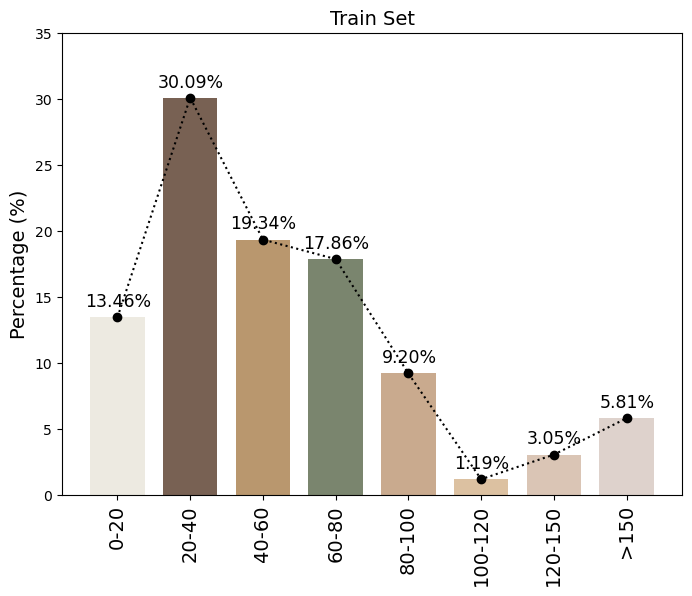

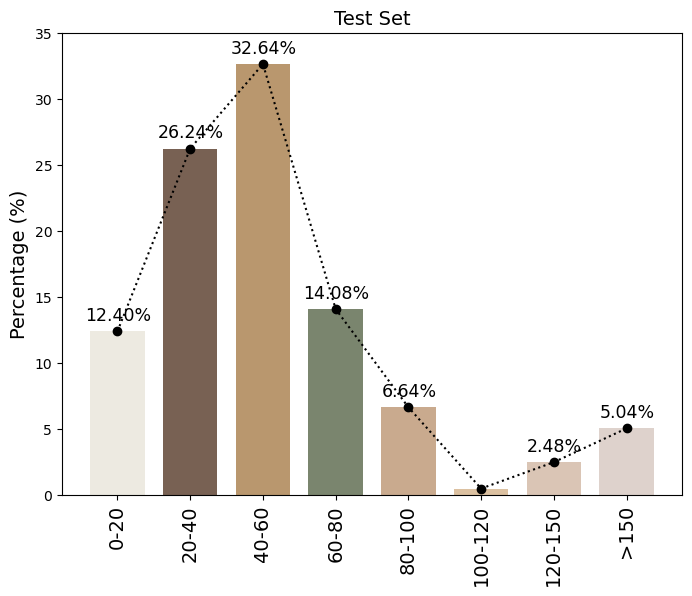

p_value canopus ls 2.0393077034171195e-19



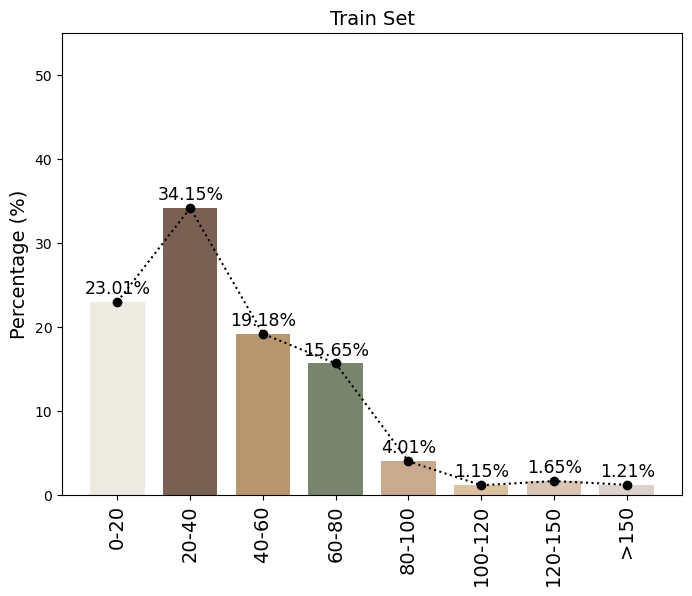

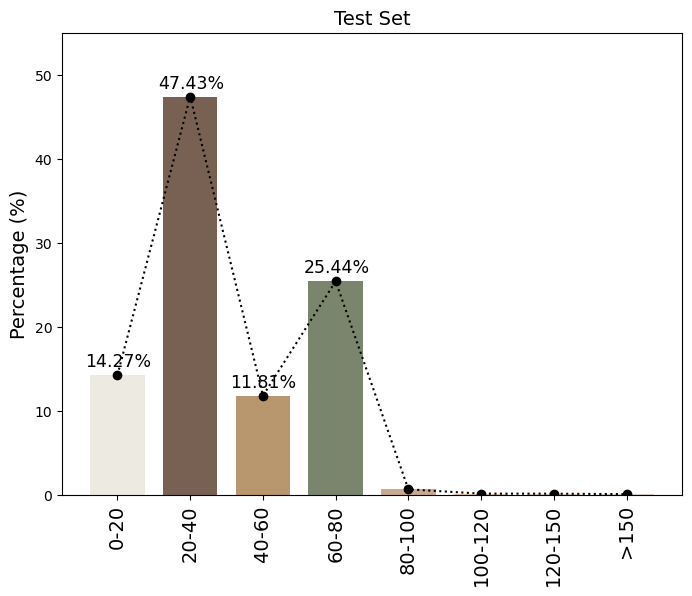

p_value massspecgym ls 0.0



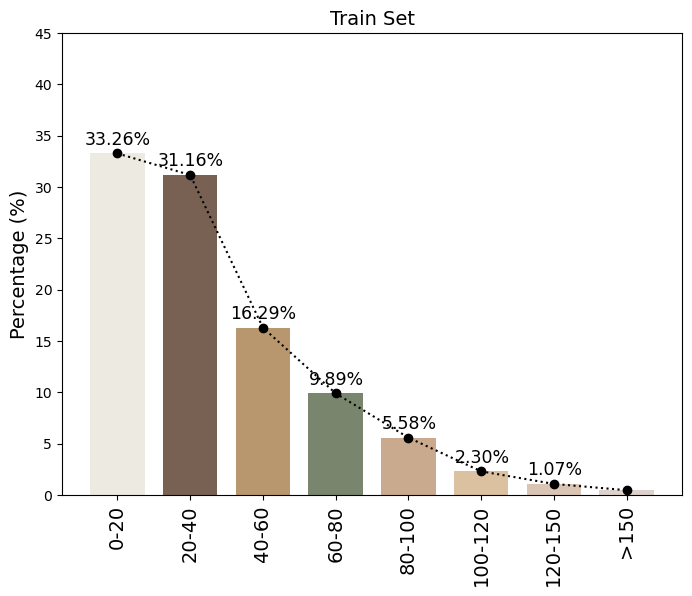

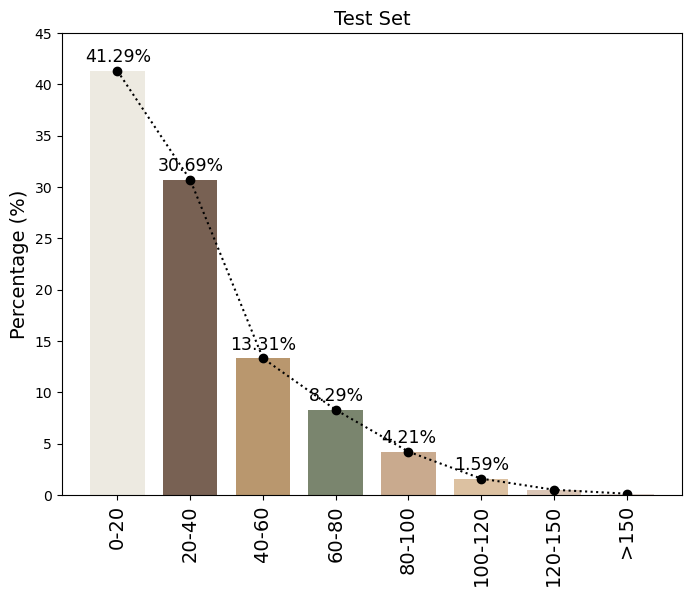

p_value nist2023 ls 5.515887009479667e-110



In [153]:
import numpy as np
import matplotlib.pyplot as plt
import os

results_energy = {} 

for dataset in ["canopus", "massspecgym", "nist2023"]:

    results_energy[dataset] = {} 

    if dataset == "canopus": vmax = 35 
    if dataset == "massspecgym": vmax = 55
    if dataset == "nist2023": vmax = 45
    for split in ["ls"]:
        results_energy[dataset][split] = {}
        stats = load_pickle(os.path.join(analysis_folder, f"{dataset}_{split}_stats.pkl"))

        plt.figure(figsize=(8, 6))
        bar_width = 0.75

        energy_bins = ["0-20", "20-40", "40-60", "60-80", "80-100", "100-120", "120-150", ">150"]
        (train_binned_energy_breakdown, _), (test_binned_energy_breakdown, _), _ = stats["energy_breakdown"]
        train_binned_energy_counts = {e: train_binned_energy_breakdown[e] for e in energy_bins}
        test_binned_energy_counts = {e: test_binned_energy_breakdown[e] for e in energy_bins}
        n_train = sum(train_binned_energy_counts.values())
        n_test = sum(test_binned_energy_counts.values())

        train_binned_energy_percent = {e: train_binned_energy_counts[e] / n_train * 100 for e in energy_bins}
        test_binned_energy_percent = {e: test_binned_energy_counts[e] / n_test * 100 for e in energy_bins}

        results_energy[dataset][split]["counts"] = test_binned_energy_counts

        selected_energy_bins = energy_bins
        x = np.arange(len(selected_energy_bins))

        # Bar plot
        plt.bar(x, [train_binned_energy_percent[e] for e in selected_energy_bins],
                bar_width, label="Train", alpha=0.75, color = energy_colors)
        
        for xi, val in zip(x, train_binned_energy_percent.values()):
            if val > 1:  # Optional: show only if >1%
                plt.text(xi + 0.01, val + 0.5, f"{val:.2f}%", ha='center', va='bottom', fontsize=12.5)
                
        # Curve overlay
        plt.plot(x, [train_binned_energy_percent[e] for e in selected_energy_bins],
                 color='black', marker='o', linestyle='dotted', label="Train (Curve)")

        # Formatting
        plt.ylabel('Percentage (%)', fontsize=14)
        plt.xticks(x, selected_energy_bins, fontsize=14, rotation=90)
        plt.ylim([0, vmax])

        dataset_ = dataset_mapping[dataset]
        split_ = splits_mapping[split]
        plt.title(f"Train Set", fontsize=14)

        energy_output_path = os.path.join(ls_plots_folder, f"{dataset}_{split}_energy_bins_train.jpg")
        plt.savefig(energy_output_path, bbox_inches="tight")
        plt.show()

        plt.figure(figsize=(8, 6))
        bar_width = 0.75

        # Bar plot
        plt.bar(x, [test_binned_energy_percent[e] for e in selected_energy_bins],
                bar_width, label="Train", alpha=0.75, color = energy_colors)

        for xi, val in zip(x, test_binned_energy_percent.values()):
            if val > 1:  # Optional: show only if >1%
                plt.text(xi + 0.01, val + 0.5, f"{val:.2f}%", ha='center', va='bottom', fontsize=12.5)

        # Curve overlay
        plt.plot(x, [test_binned_energy_percent[e] for e in selected_energy_bins],
                 color='black', marker='o', linestyle='dotted', label="Train (Curve)")

        # Formatting
        plt.ylabel('Percentage (%)', fontsize=14)
        plt.xticks(x, selected_energy_bins, fontsize=14, rotation=90)
        plt.ylim([0, vmax])

        dataset_ = dataset_mapping[dataset]
        split_ = splits_mapping[split]
        plt.title(f"Test Set", fontsize=14)

        energy_output_path = os.path.join(ls_plots_folder, f"{dataset}_{split}_energy_bins_test.jpg")
        plt.savefig(energy_output_path, bbox_inches="tight")
        plt.show()

        # Example: counts of instruments in train and test sets
        data = pd.DataFrame({
            'Train': list(train_binned_energy_counts.values()),
            'Test': list(test_binned_energy_counts.values()),
        }, list(train_binned_energy_counts.keys()))

        print("p_value", dataset, split, chi2_contingency(data)[1])
        print()